# Final training and visualising notebook

- Manual and Rule 4 event classification with different datasets

- Manual and Rule 4 Duration classification with different datasets

-  Rule 4 Duration pre-event classification with different datasets

- Feature importance test for Rule 4

In [0]:
import numpy as np
import pandas as pd 
import pandas_profiling as pp

import time
import datetime as dt
import matplotlib.dates as mdates

%matplotlib inline
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics.scorer import make_scorer

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV


from os.path import isfile, join
from termcolor import colored
import pickle

plt.style.use('fivethirtyeight')

# Load new dataset with all features + other relevant datasets, run basic XGBOOST with no parameter tuning ant visualise the results

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
feat = pd.read_csv('../gdrive/My Drive/Colab Notebooks/SWISS/0_Data/model_data_all_features_extended.csv', index_col=0)

In [0]:
feat['month'] = pd.to_datetime(feat['datetime']).dt.month
feat['hour'] = pd.to_datetime(feat['datetime']).dt.hour

In [0]:
cf = pd.read_csv('../gdrive/My Drive/Colab Notebooks/SWISS/0_Data/length_classes_manual_rule4.csv', index_col=0)
cf.tail()

datetime  ...  rule4_duration_class
262796  2018-12-30 23:20:00  ...                     0
262797  2018-12-30 23:30:00  ...                     0
262798  2018-12-30 23:40:00  ...                     0
262799  2018-12-30 23:50:00  ...                     0
262800           2018-12-31  ...                     0

[5 rows x 5 columns]

In [0]:
cf['datetime'].loc[262800] = "2018-12-31 00:00:00"

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
start = pd.read_csv('../gdrive/My Drive/Colab Notebooks/SWISS/0_Data/bise_classifications_start_end.csv')

start.tail()

datetime  rule3_episode  ...  manual_bise_start  manual_bise_end
262796  2018-12-30 23:20:00            NaN  ...                  0              0.0
262797  2018-12-30 23:30:00            NaN  ...                  0              0.0
262798  2018-12-30 23:40:00            NaN  ...                  0              0.0
262799  2018-12-30 23:50:00            NaN  ...                  0              0.0
262800  2018-12-31 00:00:00            NaN  ...                  0              NaN

[5 rows x 14 columns]

In [0]:
start['rule4_end'].loc[262800] = 0
start['manual_bise_end'].loc[262800] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
start.tail()

datetime  rule3_episode  ...  manual_bise_start  manual_bise_end
262796  2018-12-30 23:20:00            NaN  ...                  0              0.0
262797  2018-12-30 23:30:00            NaN  ...                  0              0.0
262798  2018-12-30 23:40:00            NaN  ...                  0              0.0
262799  2018-12-30 23:50:00            NaN  ...                  0              0.0
262800  2018-12-31 00:00:00            NaN  ...                  0              0.0

[5 rows x 14 columns]

In [0]:
# Create a df merging classifications and all features

df = pd.merge(cf, feat, on='datetime', how="left")

In [0]:
df.tail()

datetime  manual_bise  ...  month  hour
262796  2018-12-30 23:20:00            0  ...     12    23
262797  2018-12-30 23:30:00            0  ...     12    23
262798  2018-12-30 23:40:00            0  ...     12    23
262799  2018-12-30 23:50:00            0  ...     12    23
262800  2018-12-31 00:00:00            0  ...     12     0

[5 rows x 823 columns]

In [0]:
# Add rule4 event start/end columns 

df['rule4_end'] = start['rule4_end'].values
df['rule4_start'] = start['rule4_start'].values


df['rule4_start'].value_counts()

0    262439
1       362
Name: rule4_start, dtype: int64

## Creating feature sets

In [0]:
features_KLO = ['hour', 'month',
"KLO_Air_temp",
"KLO_Hum",
"KLO_QNH",
"KLO_Wind_dir",
"KLO_Wind_max",
"KLO_Wind_speed"
]

In [0]:
features_KLO_ALL = ['hour', 'month',
"KLO_Air_temp",
"KLO_Hum",
"KLO_Hum_delta_3",
"KLO_Hum_delta_6",
"KLO_QNH",
"KLO_Wind_dir",
"KLO_Wind_dir_delta",
"KLO_Wind_dir_delta-3",
"KLO_Wind_dir_delta-6",
"KLO_Wind_dir_spread30",
"KLO_Wind_dir_spread60",
"KLO_Wind_max_EW",
"KLO_Wind_max_NS",
"KLO_Wind_max",
"KLO_Wind_max_delta_3",
"KLO_Wind_max_delta_6",
"KLO_Wind_speed_EW",
"KLO_Wind_speed_NS",
"KLO_Wind_speed",
"KLO_Wind_speed_delta_3",
"KLO_Wind_speed_delta_6",
"QNH_BIZ_minus_KLO",
"QNH_BIZ_minus_KLO_delta",
"QNH_BIZ_minus_KLO_delta_2",
"QNH_BIZ_minus_KLO_delta_6",
"QNH_BUS_minus_KLO",
"QNH_BUS_minus_KLO_delta",
"QNH_BUS_minus_KLO_delta_2",
"QNH_BUS_minus_KLO_delta_6",
"QNH_GUT_minus_KLO",
"QNH_GUT_minus_KLO_delta",
"QNH_GUT_minus_KLO_delta_2",
"QNH_GUT_minus_KLO_delta_6",
"QNH_KLO_minus_KOP",
"QNH_KLO_minus_KOP_delta",
"QNH_KLO_minus_KOP_delta_2",
"QNH_KLO_minus_KOP_delta_6",
"QNH_KLO_minus_MOA",
"QNH_KLO_minus_MOA_delta",
"QNH_KLO_minus_MOA_delta_2",
"QNH_KLO_minus_MOA_delta_6",
"QNH_KLO_minus_MUB",
"QNH_KLO_minus_MUB_delta",
"QNH_KLO_minus_MUB_delta_2",
"QNH_KLO_minus_MUB_delta_6",
"QNH_KLO_minus_PAY",
"QNH_KLO_minus_PAY_delta",
"QNH_KLO_minus_PAY_delta_2",
"QNH_KLO_minus_PAY_delta_6",
"QNH_KLO_minus_PUY",
"QNH_KLO_minus_PUY_delta",
"QNH_KLO_minus_PUY_delta_2",
"QNH_KLO_minus_PUY_delta_6",
"QNH_KLO_minus_REH",
"QNH_KLO_minus_REH_delta",
"QNH_KLO_minus_REH_delta_2",
"QNH_KLO_minus_REH_delta_6",
"QNH_KLO_minus_SHA",
"QNH_KLO_minus_SHA_delta",
"QNH_KLO_minus_SHA_delta_2",
"QNH_KLO_minus_SHA_delta_6",
"QNH_KLO_minus_SMA",
"QNH_KLO_minus_SMA_delta",
"QNH_KLO_minus_SMA_delta_2",
"QNH_KLO_minus_SMA_delta_6",
"QNH_KLO_minus_TAE",
"QNH_KLO_minus_TAE_delta",
"QNH_KLO_minus_TAE_delta_2",
"QNH_KLO_minus_TAE_delta_6",
"QNH_KLO_minus_VAD",
"QNH_KLO_minus_VAD_delta",
"QNH_KLO_minus_VAD_delta_2",
"QNH_KLO_minus_VAD_delta_6",
"QNH_KLO_minus_WAE",
"QNH_KLO_minus_WAE_delta",
"QNH_KLO_minus_WAE_delta_2",
"QNH_KLO_minus_WAE_delta_6",
"QNH_KLO_minus_WYN",
"QNH_KLO_minus_WYN_delta",
"QNH_KLO_minus_WYN_delta_2",
"QNH_KLO_minus_WYN_delta_6"]

In [0]:
# All features except datetime column

all_features = list(feat.columns)
features_all = all_features[1:]

## Functions

In [0]:
# Binary classification

def plain_training_gpu(predicted_value, features):
    
    """
    Creates train/test datasets
    Trains model
    Visualises result
    
    """
    
#################
    start = time.time()
    
    prediction = 2
    
    # Create the train test data sets
    X_train = df_train[features][:-prediction] # everything except the 2 last values
    y_train = df_train[predicted_value][prediction:] # offset by 20mins

    X_test = df_test[features][:-prediction]  # everything except the 2 last values
    y_test = df_test[predicted_value][prediction:] # offset by 20mins
    

#################    

    XGB = XGBClassifier(objective = 'binary:logistic', gpu_id=0, tree_method = "gpu_hist")

    XGB.fit(X_train, y_train)
    #XGB.fit(X_train, y_train, sample_weight = df_train['rule4_end_weights'])
    y_pred = XGB.predict(X_test)
    
    end = time.time()
    minutes = (end - start)/60
    print()
    print('Runtime {} minutes'.format(minutes))

#################    

    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
       

In [0]:
# Multilabel classification

def plain_multiclass_training_gpu(predicted_value, features):
    
    """
    Creates train/test datasets
    Trains model
    Visualises result
    
    """
#################

    start = time.time()
    
    prediction = 2
    
    # Create the train test data sets
    X_train = df_train[features][:-prediction] # everything except the 2 last values
    y_train = df_train[predicted_value][prediction:] # offset by 20mins

    X_test = df_test[features][:-prediction]  # everything except the 2 last values
    y_test = df_test[predicted_value][prediction:] # offset by 20mins
    

#################    

    XGB = XGBClassifier(objective = "multi:softprob", num_class=4, gpu_id=0, tree_method = "gpu_hist")

    XGB.fit(X_train, y_train)
    #XGB.fit(X_train, y_train, sample_weight = df_train['rule4_end_weights'])
    y_pred = XGB.predict(X_test)
    
    end = time.time()
    minutes = (end - start)/60
    print()
    print('Runtime {} minutes'.format(minutes))

#################    

    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(7,7))
    sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
       

# Run the models

# Classifications - Events

In [0]:
df['year'] = pd.to_datetime(df['datetime']).dt.year
df['month'] = pd.to_datetime(df['datetime']).dt.month
df['hour'] = pd.to_datetime(df['datetime']).dt.hour

df_train = df[df['year']<2018]
df_test = df[df['year']==2018]

## Manual classification


Runtime 0.006894302368164062 minutes
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     45125
           1       0.80      0.27      0.41      7290

    accuracy                           0.89     52415
   macro avg       0.85      0.63      0.67     52415
weighted avg       0.88      0.89      0.86     52415



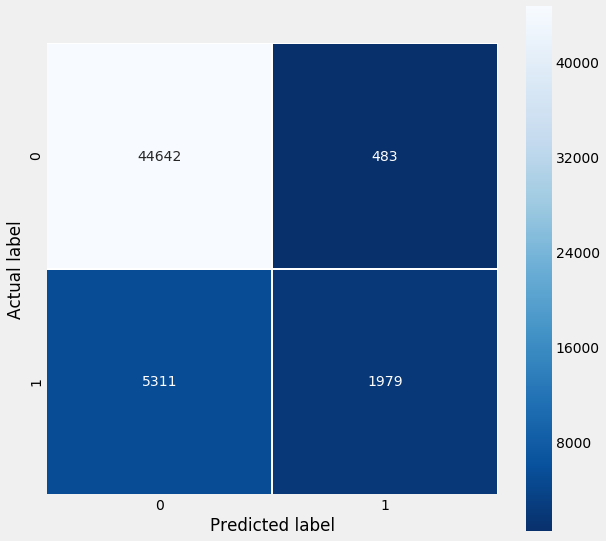

In [0]:
plain_training_gpu('manual_bise', features = ['QNH_GUT_minus_PAY'])

In [0]:
plain_training_gpu('manual_bise', features = features_KLO)


Runtime 0.0198320468266805 minutes
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     45125
           1       0.85      0.74      0.79      7290

    accuracy                           0.95     52415
   macro avg       0.91      0.86      0.88     52415
weighted avg       0.94      0.95      0.94     52415



In [0]:
plain_training_gpu('manual_bise', features = features_KLO_ALL)


Runtime 0.21729860305786133 minutes
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     45125
           1       0.87      0.78      0.82      7290

    accuracy                           0.95     52415
   macro avg       0.92      0.88      0.90     52415
weighted avg       0.95      0.95      0.95     52415



In [0]:
plain_training_gpu('manual_bise', features = features_all)


Runtime 0.8697489817937215 minutes
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     45125
           1       0.86      0.80      0.83      7290

    accuracy                           0.95     52415
   macro avg       0.91      0.89      0.90     52415
weighted avg       0.95      0.95      0.95     52415



## Rule 4 classification


Runtime 0.006972126166025798 minutes
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     49780
           1       0.68      0.19      0.30      2635

    accuracy                           0.95     52415
   macro avg       0.82      0.59      0.64     52415
weighted avg       0.94      0.95      0.94     52415



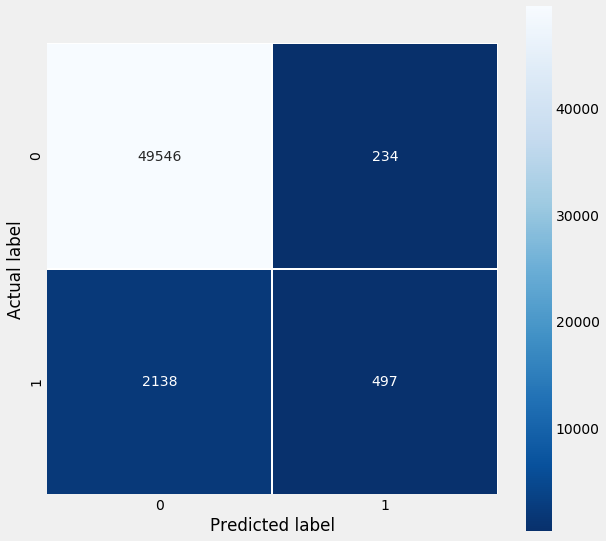

In [0]:


plain_training_gpu('rule4_episode_1_0', features = ['QNH_GUT_minus_PAY'])


Runtime 0.009441415468851725 minutes
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49780
           1       0.84      0.77      0.80      2635

    accuracy                           0.98     52415
   macro avg       0.92      0.88      0.90     52415
weighted avg       0.98      0.98      0.98     52415



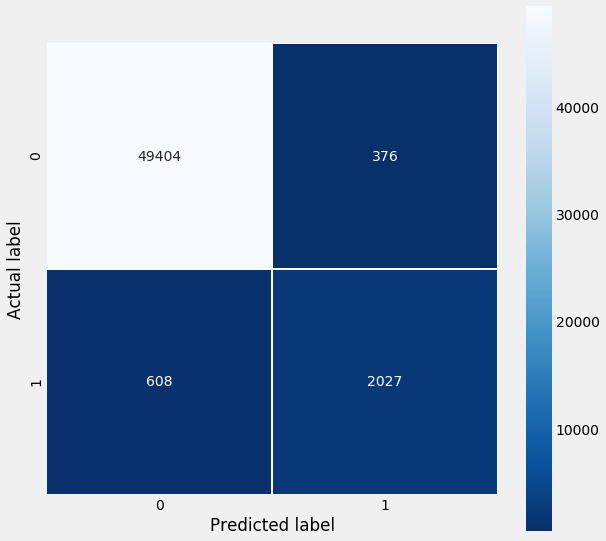

In [0]:
plain_training_gpu('rule4_episode_1_0', features = features_KLO)

In [0]:
plain_training_gpu('rule4_episode_1_0', features = features_KLO_ALL)


Runtime 0.2007505496342977 minutes
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49780
           1       0.87      0.77      0.82      2635

    accuracy                           0.98     52415
   macro avg       0.93      0.88      0.90     52415
weighted avg       0.98      0.98      0.98     52415



In [0]:
plain_training_gpu('rule4_episode_1_0', features = features_all)


Runtime 0.19699746767679852 minutes
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49780
           1       0.86      0.80      0.83      2635

    accuracy                           0.98     52415
   macro avg       0.92      0.90      0.91     52415
weighted avg       0.98      0.98      0.98     52415



### Do a CV to check scores (Pawel's idea)

In [0]:
    prediction = 2
    
    # Create the train test data sets
    X_train = df_train[features_KLO_ALL][:-prediction] # everything except the 2 last values
    y_train = df_train['rule4_episode_1_0'][prediction:] # offset by 20mins

    X_test = df_test[features_KLO_ALL][:-prediction]  # everything except the 2 last values
    y_test = df_test['rule4_episode_1_0'][prediction:] # offset by 20mins
    

#################    

    XGB = XGBClassifier(objective = 'binary:logistic', gpu_id=0, tree_method = "gpu_hist")


In [0]:
abc = cross_validate(XGB, X_test, y=y_test, groups=None, scoring='precision', cv=5, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False, return_estimator=False, error_score='raise-deprecating')

In [0]:
abc

{'fit_time': array([3.1074543 , 2.87690091, 2.8137641 , 2.83758807, 2.91743183]),
 'score_time': array([0.02517748, 0.02486944, 0.02468467, 0.02634501, 0.02575493]),
 'test_score': array([0.6721044 , 0.71764706, 0.54820144, 0.8579235 , 0.90304709])}

## Rule 4 start


Runtime 0.009020785490671793 minutes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52309
           1       0.00      0.00      0.00       106

    accuracy                           1.00     52415
   macro avg       0.50      0.50      0.50     52415
weighted avg       1.00      1.00      1.00     52415



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


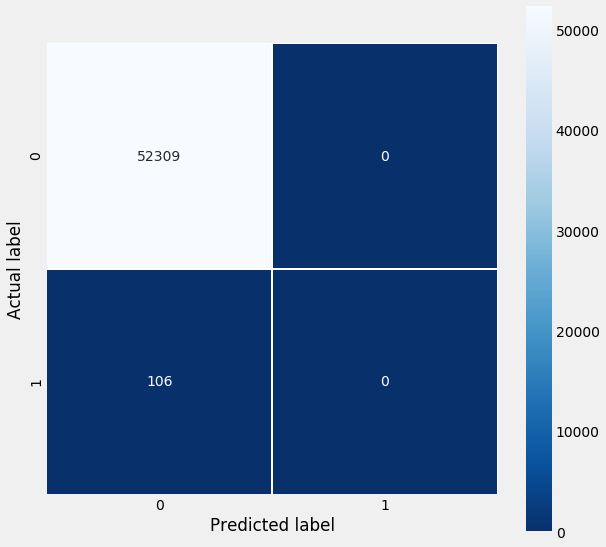

In [0]:
plain_training_gpu('rule4_start', features = features_KLO)


Runtime 0.021349632740020753 minutes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52309
           1       0.00      0.00      0.00       106

    accuracy                           1.00     52415
   macro avg       0.50      0.50      0.50     52415
weighted avg       1.00      1.00      1.00     52415



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


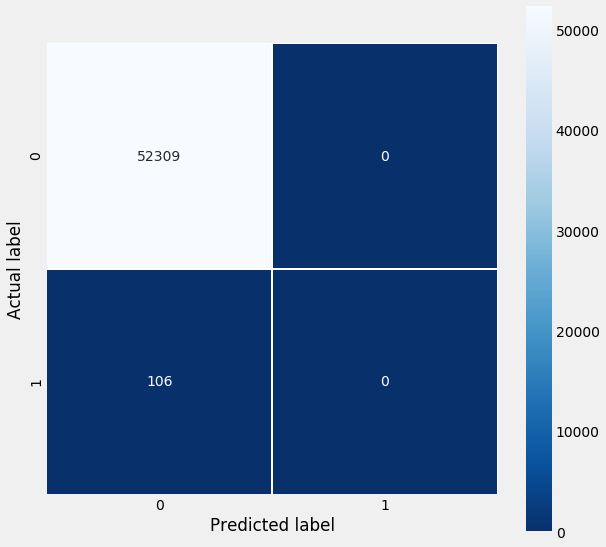

In [0]:
plain_training_gpu('rule4_start', features = features_KLO_ALL)


Runtime 0.1894437591234843 minutes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52309
           1       0.00      0.00      0.00       106

    accuracy                           1.00     52415
   macro avg       0.50      0.50      0.50     52415
weighted avg       1.00      1.00      1.00     52415



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


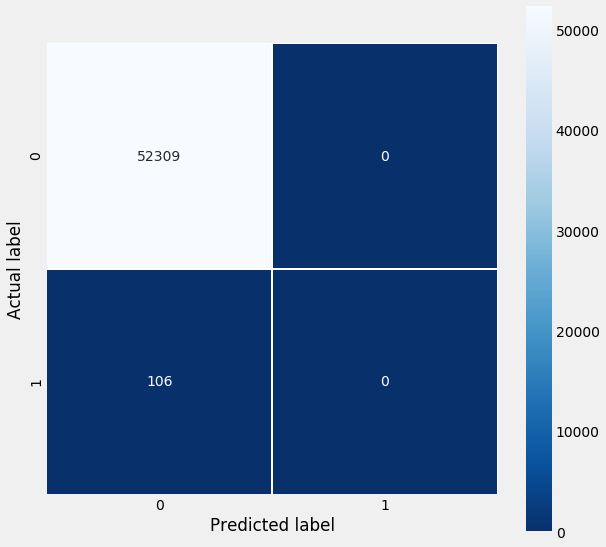

In [0]:
plain_training_gpu('rule4_start', features = features_all)

## Rule 4 end


Runtime 0.008191895484924317 minutes
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     52309
         1.0       0.00      0.00      0.00       106

    accuracy                           1.00     52415
   macro avg       0.50      0.50      0.50     52415
weighted avg       1.00      1.00      1.00     52415



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


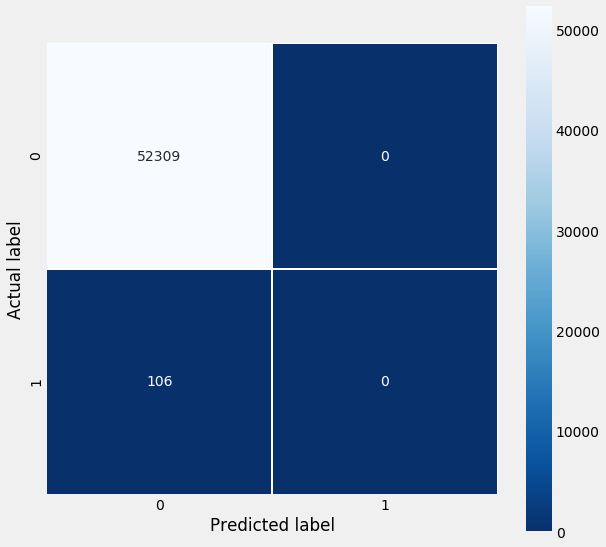

In [0]:
plain_training_gpu('rule4_end', features = features_KLO)


Runtime 0.020800264676411946 minutes
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     52309
         1.0       0.00      0.00      0.00       106

    accuracy                           1.00     52415
   macro avg       0.50      0.50      0.50     52415
weighted avg       1.00      1.00      1.00     52415



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


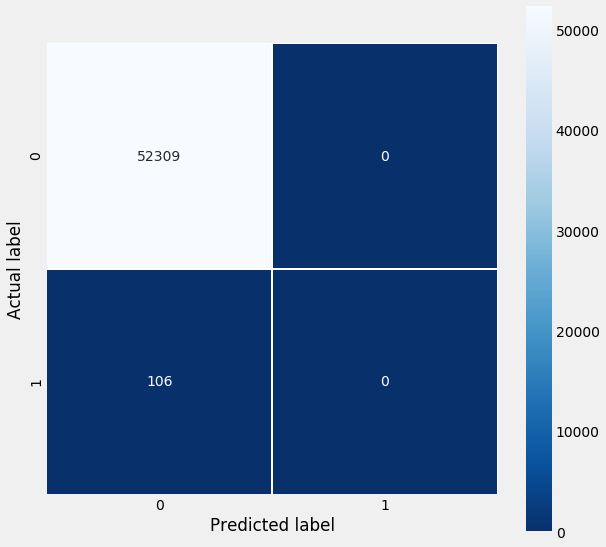

In [0]:
plain_training_gpu('rule4_end', features = features_KLO_ALL)


Runtime 0.16125969489415487 minutes
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     52309
         1.0       0.00      0.00      0.00       106

    accuracy                           1.00     52415
   macro avg       0.50      0.50      0.50     52415
weighted avg       1.00      1.00      1.00     52415



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


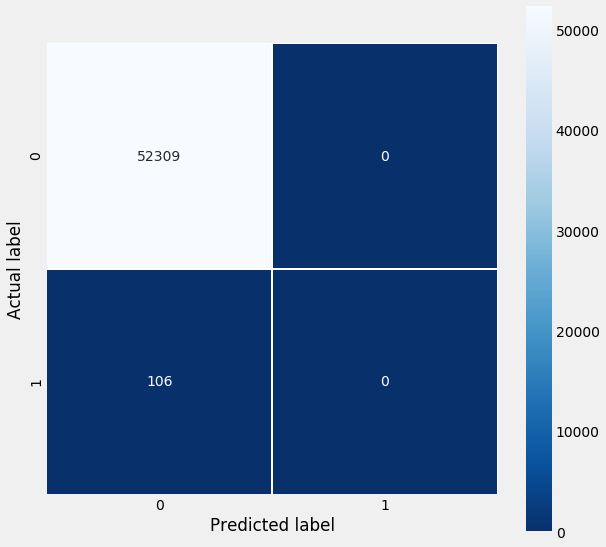

In [0]:
plain_training_gpu('rule4_end', features = features_all)

## Rule 4 end with weights


In [0]:
def gpu_binary_train_test_modeling(predicted_value, features):
    
    prediction = 2
    
    # Create the train test data sets
    X_train = df_train[features][:-prediction] # everything except the 2 last values
    y_train = df_train[predicted_value][prediction:] # offset by 20mins

    X_test = df_test[features][:-prediction]  # everything except the 2 last values
    y_test = df_test[predicted_value][prediction:] # offset by 20mins
    

    parameters = {    "scale_pos_weight": [300,400,500,600,700],
                      "n_estimators": [100,200],

             }

  
    XGB = XGBClassifier(objective = 'binary:logistic', gpu_id=0, tree_method = "gpu_hist")
    XGB_base_rand = RandomizedSearchCV(XGB, parameters, cv=3, scoring = "precision", return_train_score=True)
    XGB_base_rand.fit(X_train, y_train)

    print(XGB_base_rand.best_params_)
    print(XGB_base_rand.best_score_)
    print('Test score: {}'.format(XGB_base_rand.score(X_test, y_test)))

In [0]:
gpu_binary_train_test_modeling('rule4_end', features = features_all)

{'scale_pos_weight': 300, 'n_estimators': 200}
0.07939502791409436
Test score: 0.0710594315245478


In [0]:
# Binary classification

def weights_plain_training_gpu(predicted_value, weights, estimators, features):
    
    """
    Creates train/test datasets
    Trains model
    Visualises result
    
    """
    
#################
    start = time.time()
    
    prediction = 2
    
    # Create the train test data sets
    X_train = df_train[features][:-prediction] # everything except the 2 last values
    y_train = df_train[predicted_value][prediction:] # offset by 20mins

    X_test = df_test[features][:-prediction]  # everything except the 2 last values
    y_test = df_test[predicted_value][prediction:] # offset by 20mins
    

#################    

    XGB = XGBClassifier(objective = 'binary:logistic', gpu_id=0, tree_method = "gpu_hist", n_estimators=estimators, scale_pos_weight = weights)

    XGB.fit(X_train, y_train)
    #XGB.fit(X_train, y_train, sample_weight = df_train['rule4_end_weights'])
    y_pred = XGB.predict(X_test)
    
    end = time.time()
    minutes = (end - start)/60
    print()
    print('Runtime {} minutes'.format(minutes))

#################    

    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
       

In [0]:
weights_plain_training_gpu('rule4_end', 300, 200, features = features_all)


Runtime 0.2219613830248515 minutes
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     52309
         1.0       0.07      0.52      0.12       106

    accuracy                           0.99     52415
   macro avg       0.54      0.75      0.56     52415
weighted avg       1.00      0.99      0.99     52415



# Classifications - Duration


## Rule 4

In [0]:
plain_multiclass_training_gpu('rule4_duration_class', features_KLO)


Runtime 0.041362571716308597 minutes
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     49780
           1       0.34      0.08      0.13       676
           2       0.44      0.37      0.40      1068
           3       0.60      0.59      0.60       891

    accuracy                           0.96     52415
   macro avg       0.59      0.51      0.53     52415
weighted avg       0.96      0.96      0.96     52415




Runtime 0.0697074810663859 minutes
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     49780
           1       0.34      0.11      0.16       676
           2       0.51      0.43      0.47      1068
           3       0.65      0.69      0.67       891

    accuracy                           0.97     52415
   macro avg       0.62      0.55      0.57     52415
weighted avg       0.96      0.97      0.96     52415



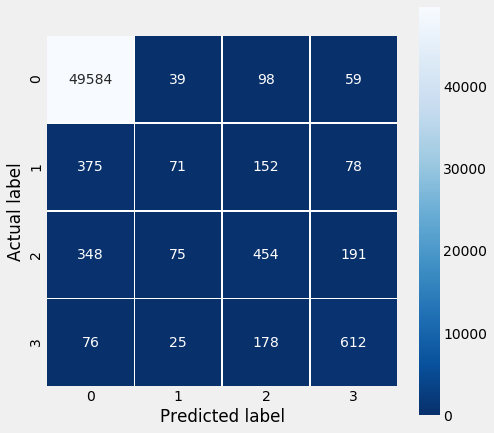

In [0]:
plain_multiclass_training_gpu('rule4_duration_class', features_KLO_ALL)


Runtime 0.3405903180440267 minutes
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     49780
           1       0.34      0.11      0.16       676
           2       0.53      0.44      0.48      1068
           3       0.66      0.73      0.70       891

    accuracy                           0.97     52415
   macro avg       0.63      0.57      0.58     52415
weighted avg       0.96      0.97      0.96     52415



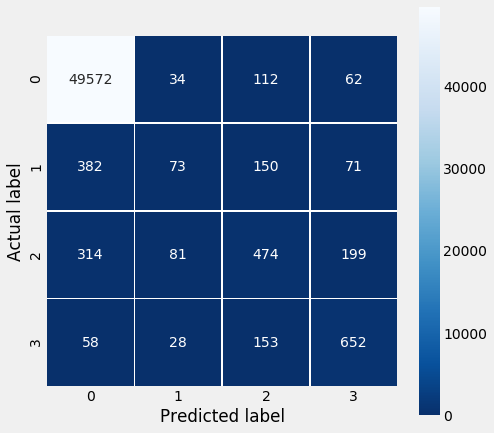

In [0]:
plain_multiclass_training_gpu('rule4_duration_class', features_all)

## Manual


Runtime 0.04134994347890218 minutes
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     45125
           1       0.29      0.15      0.20      1695
           2       0.46      0.51      0.48      2512
           3       0.68      0.43      0.53      3083

    accuracy                           0.90     52415
   macro avg       0.60      0.52      0.54     52415
weighted avg       0.89      0.90      0.89     52415



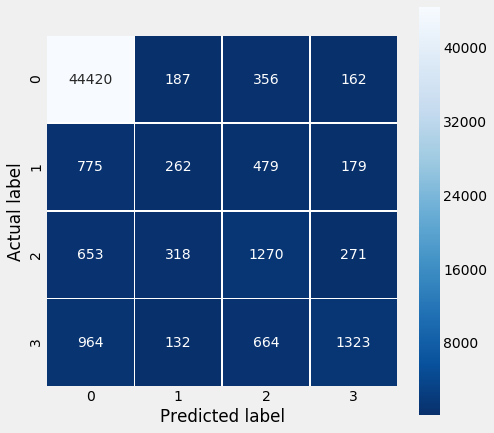

In [0]:
plain_multiclass_training_gpu('manual_duration_class', features_KLO)


Runtime 0.07152554591496786 minutes
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     45125
           1       0.42      0.22      0.29      1695
           2       0.49      0.54      0.51      2512
           3       0.68      0.47      0.55      3083

    accuracy                           0.91     52415
   macro avg       0.64      0.55      0.58     52415
weighted avg       0.90      0.91      0.90     52415



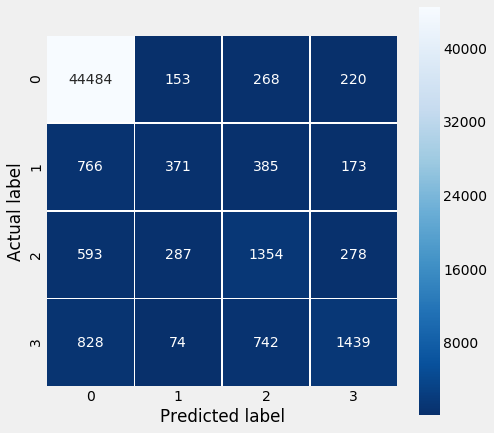

In [0]:
plain_multiclass_training_gpu('manual_duration_class', features_KLO_ALL)


Runtime 0.35963406165440875 minutes
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     45125
           1       0.38      0.24      0.30      1695
           2       0.50      0.54      0.52      2512
           3       0.71      0.49      0.58      3083

    accuracy                           0.91     52415
   macro avg       0.63      0.56      0.59     52415
weighted avg       0.90      0.91      0.90     52415



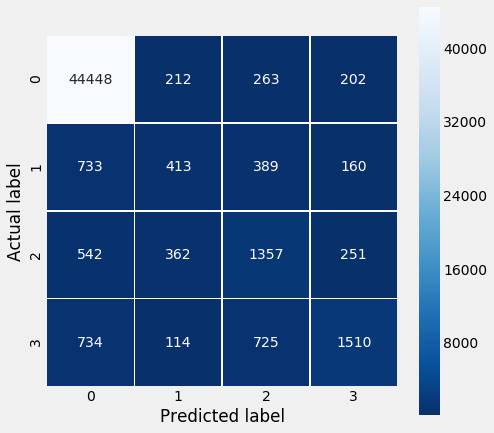

In [0]:
plain_multiclass_training_gpu('manual_duration_class', features_all)

# Classifications - Duration (labels before event -120mins to +50 mins)

Rule 4

In [0]:
pre_event = pd.read_csv('../gdrive/My Drive/Colab Notebooks/SWISS/0_Data/durations_labels_pre_event.csv.zip', index_col=0)

In [0]:
# Add columns and split dataset 

df['pre_rule4_duration_class'] = pre_event['pre_rule4_duration_class']

df_train = df[df['year']<2018]
df_test = df[df['year']==2018]

In [0]:
df_train['pre_rule4_duration_class'].value_counts()

0    205927
1      2837
2      1188
3       432
Name: pre_rule4_duration_class, dtype: int64


Runtime 0.042062095801035565 minutes
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     50572
           1       0.52      0.01      0.02      1015
           2       0.00      0.00      0.00       648
           3       0.00      0.00      0.00       180

    accuracy                           0.96     52415
   macro avg       0.37      0.25      0.25     52415
weighted avg       0.94      0.96      0.95     52415



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


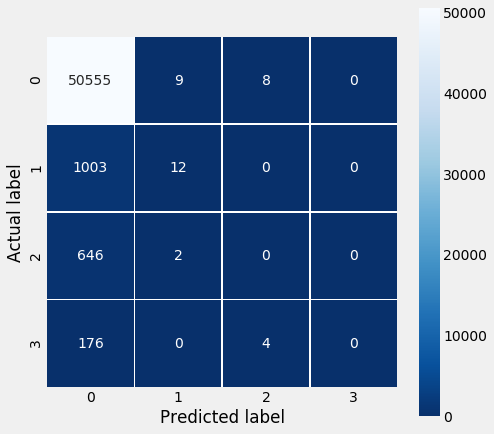

In [0]:
plain_multiclass_training_gpu('pre_rule4_duration_class', features_KLO)

## Failed to classify, introducing weights for classes

In [0]:
from sklearn.utils import class_weight

class_weights_rule4 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(df['pre_rule4_duration_class'].values), y= df['pre_rule4_duration_class'].values)
class_weights_rule4

array([  0.25614033,  17.05613967,  35.78444989, 107.35334967])

In [0]:
# Add weights

df['pre_rule4_duration_class_weights'] = 0

df.loc[df['pre_rule4_duration_class'] == 0, 'pre_rule4_duration_class_weights'] = 0.25614033
df.loc[df['pre_rule4_duration_class'] == 1, 'pre_rule4_duration_class_weights'] = 17.05613967
df.loc[df['pre_rule4_duration_class'] == 2, 'pre_rule4_duration_class_weights'] = 35.78444989
df.loc[df['pre_rule4_duration_class'] == 3, 'pre_rule4_duration_class_weights'] = 107.35334967

df_train = df[df['year']<2018]
df_test = df[df['year']==2018]

In [0]:
# change classification function
def plain_multiclass_training_gpu_weights(predicted_value, features):
    
    """

    Train model
    Visualise result

    
    """
    start = time.time()
    
    prediction = 2
    
    # Create the train test data sets
    X_train = df_train[features][:-prediction] # everything except the 2 last values
    y_train = df_train[predicted_value][prediction:] # offset by 20mins

    X_test = df_test[features][:-prediction]  # everything except the 2 last values
    y_test = df_test[predicted_value][prediction:] # offset by 20mins
    

#################    

    XGB = XGBClassifier(objective = "multi:softprob", num_class=4, gpu_id=0, tree_method = "gpu_hist")

    #XGB.fit(X_train, y_train)
    XGB.fit(X_train, y_train, sample_weight = df_train['pre_rule4_duration_class_weights'], eval_sa)
    y_pred = XGB.predict(X_test)
    
    end = time.time()
    minutes = (end - start)/60
    print()
    print('Runtime {} minutes'.format(minutes))

#################    

    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(7,7))
    sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Runtime 0.04372755686442057 minutes
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     50572
           1       0.10      0.57      0.16      1015
           2       0.11      0.33      0.16       648
           3       0.05      0.56      0.10       180

    accuracy                           0.82     52415
   macro avg       0.31      0.57      0.33     52415
weighted avg       0.96      0.82      0.88     52415



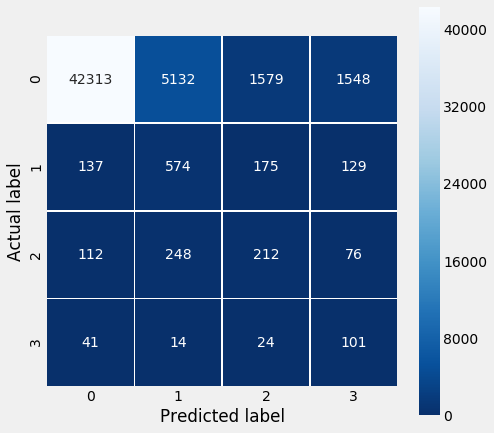

In [0]:
plain_multiclass_training_gpu_weights('pre_rule4_duration_class', features_KLO)

In [0]:
plain_multiclass_training_gpu_weights('pre_rule4_duration_class', features_KLO_ALL)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Runtime 0.07244398593902587 minutes
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     50572
           1       0.09      0.56      0.16      1015
           2       0.10      0.27      0.15       648
           3       0.06      0.43      0.10       180

    accuracy                           0.84     52415
   macro avg       0.31      0.53      0.33     52415
weighted avg       0.96      0.84      0.89     52415



/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Runtime 0.37339353958765664 minutes
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     50572
           1       0.10      0.59      0.17      1015
           2       0.15      0.28      0.19       648
           3       0.08      0.46      0.14       180

    accuracy                           0.86     52415
   macro avg       0.33      0.55      0.36     52415
weighted avg       0.96      0.86      0.90     52415



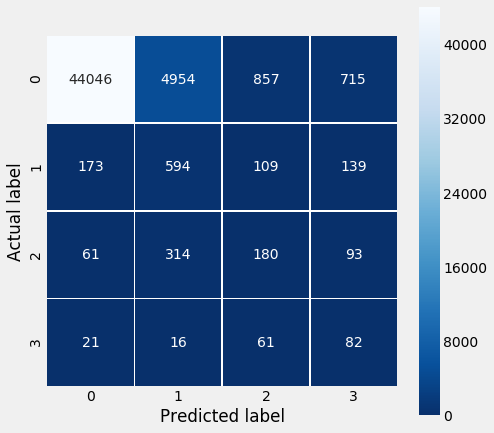

In [0]:
plain_multiclass_training_gpu_weights('pre_rule4_duration_class', features_all)

In [0]:
# increase weights for classes

df['pre_rule4_duration_class_weights'] = 0

df.loc[df['pre_rule4_duration_class'] == 0, 'pre_rule4_duration_class_weights'] = 1
df.loc[df['pre_rule4_duration_class'] == 1, 'pre_rule4_duration_class_weights'] = 50
df.loc[df['pre_rule4_duration_class'] == 2, 'pre_rule4_duration_class_weights'] = 52
df.loc[df['pre_rule4_duration_class'] == 3, 'pre_rule4_duration_class_weights'] = 250

df_train = df[df['year']<2018]
df_test = df[df['year']==2018]

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Runtime 0.3562551180521647 minutes
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     50572
           1       0.11      0.62      0.19      1015
           2       0.17      0.15      0.16       648
           3       0.08      0.42      0.14       180

    accuracy                           0.87     52415
   macro avg       0.34      0.52      0.36     52415
weighted avg       0.96      0.87      0.91     52415



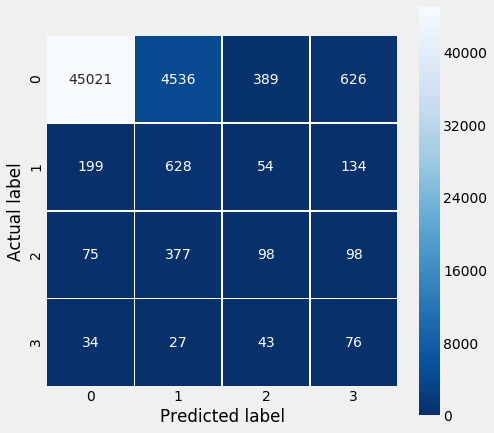

In [0]:
plain_multiclass_training_gpu_weights('pre_rule4_duration_class', features_all)

# Feature importance check

## All features, rule 4 classification

In [0]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 102kB 2.0MB/s 


## Train the model

### KLO + all features

In [0]:
    start = time.time()
    
    prediction = 2
    
    # Create the train test data sets
    X_train = df_train[features_KLO_ALL][:-prediction] # everything except the 2 last values
    y_train = df_train['rule4_episode_1_0'][prediction:] # offset by 20mins

    X_test = df_test[features_KLO_ALL][:-prediction]  # everything except the 2 last values
    y_test = df_test['rule4_episode_1_0'][prediction:] # offset by 20mins
    

#################    

    XGB = XGBClassifier(objective = 'binary:logistic', gpu_id=0, tree_method = "gpu_hist")

    XGB.fit(X_train, y_train)
    
    end = time.time()
    minutes = (end - start)/60
    print()
    print('Runtime {} minutes'.format(minutes))


Runtime 0.023587103684743246 minutes


In [0]:
start = time.time()

perm = PermutationImportance(XGB, random_state=1).fit(X_test, y_test)

end = time.time()
minutes = (end - start)/60
print()
print('Runtime {} minutes'.format(minutes))


eli5.show_weights(perm, feature_names = X_test.columns.tolist())




Runtime 0.6226072867711385 minutes


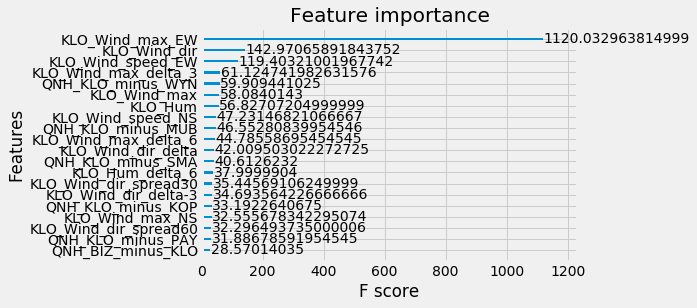

In [0]:
# plot feature importance
plot_importance(XGB, max_num_features=20, importance_type='gain')
plt.show()

### All features

In [0]:
    start = time.time()
    
    prediction = 2
    
    # Create the train test data sets
    X_train = df_train[features_all][:-prediction] # everything except the 2 last values
    y_train = df_train['rule4_episode_1_0'][prediction:] # offset by 20mins

    X_test = df_test[features_all][:-prediction]  # everything except the 2 last values
    y_test = df_test['rule4_episode_1_0'][prediction:] # offset by 20mins
    

#################    

    XGB = XGBClassifier(objective = 'binary:logistic', gpu_id=0, tree_method = "gpu_hist")

    XGB.fit(X_train, y_train)
    #XGB.fit(X_train, y_train, sample_weight = df_train['rule4_end_weights'])
    y_pred = XGB.predict(X_test)
    
    end = time.time()
    minutes = (end - start)/60
    print()
    print('Runtime {} minutes'.format(minutes))


Runtime 0.7483328501383464 minutes


In [0]:
start = time.time()

perm = PermutationImportance(XGB, random_state=1).fit(X_test, y_test)

end = time.time()
minutes = (end - start)/60
print()
print('Runtime {} minutes'.format(minutes))


eli5.show_weights(perm, feature_names = X_test.columns.tolist())


Runtime 58.80504362185796 minutes


In [0]:
# plot feature importance
plot_importance(XGB, max_num_features=20, importance_type='gain')
plt.show()